In [3]:
TRACK = "tracks/July_2020.npy"

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import math
from typing import Any, Dict, List, Tuple, Callable

ParamType = Dict[str, Any]
VecType = Tuple[float, float]


def diff_deg(deg1: float, deg2: float) -> float:
    deg_diff = abs(deg1 - deg2)
    return min(deg_diff, abs(360 - deg_diff))


def p_deg(org: VecType, to: VecType) -> float:
    x = to[0] - org[0]
    y = to[1] - org[1]
    return (math.atan2(y, x) * 180) / math.pi


def vec_bisector_angle(vec_a: VecType, vec_b: VecType) -> VecType:
    len_va = math.sqrt(vec_a[0] * vec_a[0] + vec_a[1] * vec_a[1])
    len_vb = math.sqrt(vec_b[0] * vec_b[0] + vec_b[1] * vec_b[1])

    vec_bis = (
        len_vb * vec_a[0] + len_va * vec_b[0],
        len_vb * vec_a[1] + len_va * vec_b[1],
    )
    len_bis = math.sqrt(vec_bis[0] * vec_bis[0] + vec_bis[1] * vec_bis[1])
    return (vec_bis[0] / len_bis, vec_bis[1] / len_bis)


def make_waypoints_distinct(params: ParamType) -> List[VecType]:
    wp = params["waypoints"]
    wp_cut = [wp[0]]
    for p in wp[1:-1]:
        if p != wp_cut[-1]:
            wp_cut.append(p)
    if wp_cut[0] != wp[-1]:
        wp_cut.append(wp[-1])
    return wp_cut


def aug_waypoints_horizontally(
    wp: List[VecType], params: ParamType
) -> List[List[VecType]]:
    wp_auged = []
    for i in range(len(wp) - 1):
        pre = wp[(i + len(wp) - 1) % len(wp)]
        now = wp[i]
        nex = wp[(i + 1) % len(wp)]
        vec_a = (pre[0] - now[0], pre[1] - now[1])
        vec_b = (nex[0] - now[0], nex[1] - now[1])

        vec_t = vec_bisector_angle(vec_a, vec_b)
        _fracs = [x / 10 for x in range(-6, 7)]
        fracs = [params["track_width"] * 0.5 * f for f in _fracs]
        auged = [(now[0] + vec_t[0] * f, now[1] + vec_t[1] * f) for f in fracs]
        wp_auged.append(auged)
    return wp_auged


def calc_deg_opt_path(
    entering_deg: float,
    src: Tuple[int, int],
    steps: int,
    wp_auged: List[List[VecType]],
    trans_deg: Callable[[float], float],
) -> List[int]:
    width = len(wp_auged[0])
    dp_dist = [[[float("inf")] * width for _ in range(width)] for _ in range(steps)]
    prev = [[[-1] * width for _ in range(width)] for _ in range(steps)]

    for i in range(width):
        nex = (src[0] + 1) % len(wp_auged)
        nex_deg = p_deg(wp_auged[src[0]][src[1]], wp_auged[nex][i])
        corner_deg = diff_deg(entering_deg, nex_deg)
        dp_dist[0][i][src[1]] = trans_deg(corner_deg)

    for i in range(steps - 1):
        prepre = (src[0] + i) % len(wp_auged)
        pre = (prepre + 1) % len(wp_auged)
        nex = (pre + 1) % len(wp_auged)
        for j in range(width):
            for k in range(width):
                nex_deg = p_deg(wp_auged[pre][k], wp_auged[nex][j])
                for m in range(width):
                    pre_deg = p_deg(wp_auged[prepre][m], wp_auged[pre][k])
                    corner_deg = diff_deg(pre_deg, nex_deg)
                    fun_deg = trans_deg(corner_deg)
                    if dp_dist[i][k][m] + fun_deg < dp_dist[i + 1][j][k]:
                        dp_dist[i + 1][j][k] = dp_dist[i][k][m] + fun_deg
                        prev[i + 1][j][k] = m

    min_cum_deg = float("inf")
    for j in range(width):
        for k in range(width):
            if dp_dist[steps - 1][j][k] < min_cum_deg:
                min_cum_deg = dp_dist[steps - 1][j][k]
                min_j = j
                min_k = k

    optimal_path = [min_j, min_k]
    for i in range(1, steps):
        optimal_path.append(prev[steps - i][optimal_path[-2]][optimal_path[-1]])

    return optimal_path[::-1]


In [6]:
arr = np.load(TRACK)

In [7]:
arr

array([[-0.73072696, -0.85972022, -0.7310794 , -0.40252039, -0.73037452,
        -1.31692004],
       [-1.152821  , -0.86004008, -1.15281403, -0.40283921, -1.15282798,
        -1.31724095],
       [-1.57060248, -0.86003752, -1.57058895, -0.40283599, -1.57061601,
        -1.31723905],
       ...,
       [-0.05159832, -0.86063978, -0.05047119, -0.40344161, -0.05272545,
        -1.31783795],
       [-0.38474761, -0.85981847, -0.38461721, -0.40261891, -0.38487801,
        -1.31701803],
       [-0.73072696, -0.85972022, -0.7310794 , -0.40252039, -0.73037452,
        -1.31692004]])

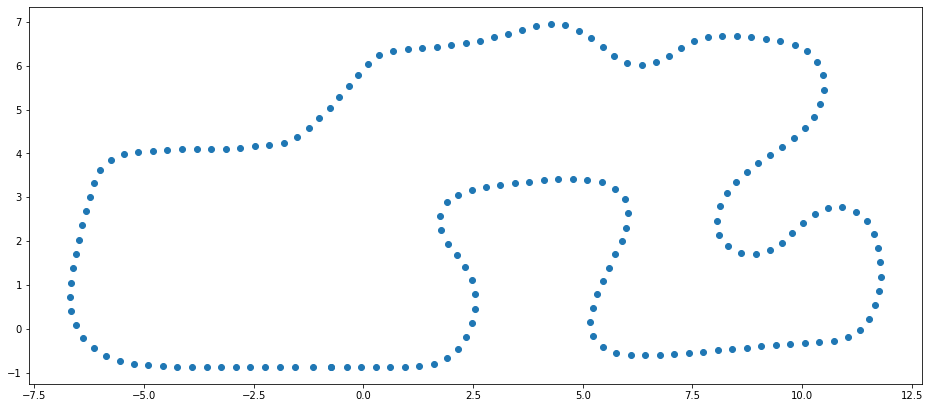

In [8]:
# センターラインのプロット
x = [p[0] for p in arr]
y = [p[1] for p in arr]

fig = plt.figure(figsize=(16, 16))
plt.axes().set_aspect('equal')
plt.scatter(x, y)

In [9]:
params = {}

In [10]:
params["waypoints"] = [(float(p[0]), float(p[1])) for p in arr]

In [11]:
x0, y0 = arr[0][2], arr[0][3]
x1, y1 = arr[0][4], arr[0][5]
dx = x0 - x1
dy = y0 - y1

params["track_width"] = math.sqrt(dx * dx + dy * dy)

In [12]:
wp_cut = make_waypoints_distinct(params)

In [13]:
wp_cut

[(-0.730726957321167, -0.8597202152013779),
 (-1.1528210043907166, -0.860040083527565),
 (-1.5706024765968323, -0.8600375205278397),
 (-1.9126494526863098, -0.8600291311740875),
 (-2.245930552482605, -0.8600251525640488),
 (-2.5782164335250854, -0.8600473701953888),
 (-2.9105329513549805, -0.8600390702486038),
 (-3.242935538291931, -0.8599974513053894),
 (-3.575163960456848, -0.860090434551239),
 (-3.907320499420166, -0.8600515574216843),
 (-4.239967584609985, -0.8587584048509598),
 (-4.572450399398804, -0.8512996733188629),
 (-4.903303623199463, -0.8300447165966034),
 (-5.232973575592041, -0.7904577404260635),
 (-5.560291528701782, -0.7261287271976471),
 (-5.8724753856658936, -0.6151338890194893),
 (-6.1529505252838135, -0.4394827075302601),
 (-6.383931398391724, -0.20243874471634626),
 (-6.5537495613098145, 0.08377861604094505),
 (-6.660109519958496, 0.3987950533628464),
 (-6.70038628578186, 0.7266036868095398),
 (-6.674363851547241, 1.0564639270305634),
 (-6.612706184387207, 1.38450

In [14]:
wp_auged = aug_waypoints_horizontally(wp_cut, params)

In [15]:
wp_auged

[[(-0.7307919454293046, -0.5854002452911848),
  (-0.7307811140779483, -0.6311202402762169),
  (-0.7307702827265921, -0.6768402352612491),
  (-0.7307594513752358, -0.7225602302462814),
  (-0.7307486200238795, -0.7682802252313135),
  (-0.7307377886725233, -0.8140002202163457),
  (-0.730726957321167, -0.8597202152013779),
  (-0.7307161259698107, -0.9054402101864101),
  (-0.7307052946184545, -0.9511602051714423),
  (-0.7306944632670982, -0.9968802001564744),
  (-0.7306836319157419, -1.0426001951415067),
  (-0.7306728005643857, -1.088320190126539),
  (-0.7306619692130294, -1.134040185111571)],
 [(-1.1527179042472602, -1.134360041761274),
  (-1.152735087604503, -1.0886400487223225),
  (-1.1527522709617457, -1.042920055683371),
  (-1.1527694543189884, -0.9972000626444195),
  (-1.152786637676231, -0.951480069605468),
  (-1.152803821033474, -0.9057600765665165),
  (-1.1528210043907166, -0.860040083527565),
  (-1.1528381877479592, -0.8143200904886135),
  (-1.152855371105202, -0.768600097449662),

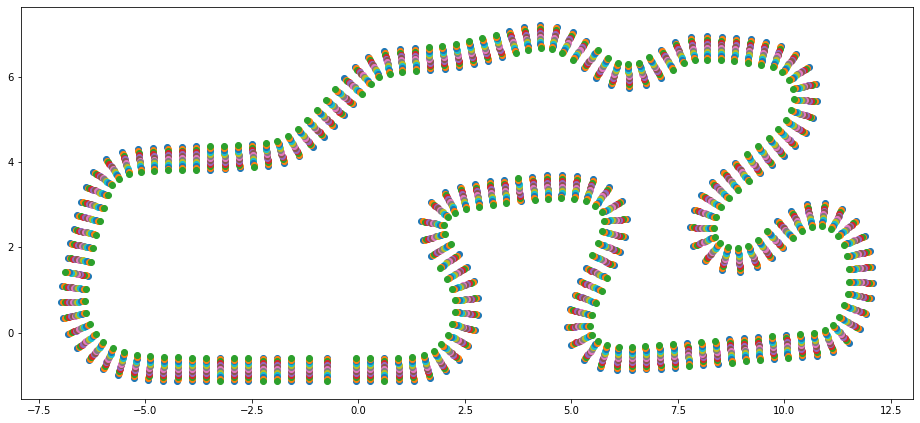

In [16]:
fig = plt.figure(figsize=(16, 16))
plt.axes().set_aspect('equal')

for i in range(len(wp_auged[0])):
    x = [p[i][0] for p in wp_auged]
    y = [p[i][1] for p in wp_auged]
    plt.scatter(x, y)

In [17]:
start_p = (0, 6)
start_deg = 180.0
steps = len(wp_auged) - 1

In [18]:
path = calc_deg_opt_path(start_deg, start_p, steps, wp_auged, lambda x: x ** 4)

In [19]:
path

[6,
 6,
 5,
 8,
 9,
 2,
 1,
 12,
 0,
 0,
 0,
 0,
 1,
 3,
 6,
 9,
 11,
 12,
 12,
 11,
 9,
 6,
 9,
 1,
 0,
 0,
 1,
 3,
 6,
 9,
 10,
 9,
 7,
 5,
 3,
 2,
 2,
 10,
 10,
 10,
 2,
 11,
 12,
 12,
 11,
 9,
 7,
 5,
 3,
 11,
 12,
 12,
 10,
 7,
 4,
 10,
 11,
 12,
 12,
 11,
 9,
 6,
 9,
 11,
 12,
 12,
 11,
 4,
 8,
 11,
 12,
 12,
 11,
 3,
 4,
 3,
 1,
 0,
 0,
 1,
 3,
 6,
 9,
 11,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 1,
 3,
 5,
 7,
 9,
 11,
 12,
 12,
 11,
 9,
 7,
 5,
 3,
 10,
 11,
 12,
 12,
 11,
 9,
 6,
 3,
 1,
 0,
 0,
 0,
 1,
 2,
 2,
 1,
 0,
 12,
 0,
 12,
 12,
 12,
 0,
 0,
 12,
 0,
 1,
 2,
 4,
 7,
 10,
 12,
 12,
 11,
 8,
 5,
 3,
 2,
 10,
 10,
 11,
 12,
 12,
 11,
 9,
 6,
 3,
 1,
 0,
 12,
 0,
 1,
 3,
 6,
 9,
 11,
 12,
 11,
 8,
 7,
 9,
 11,
 12,
 12,
 12,
 12,
 12,
 11,
 9,
 6,
 3,
 11,
 0,
 0]

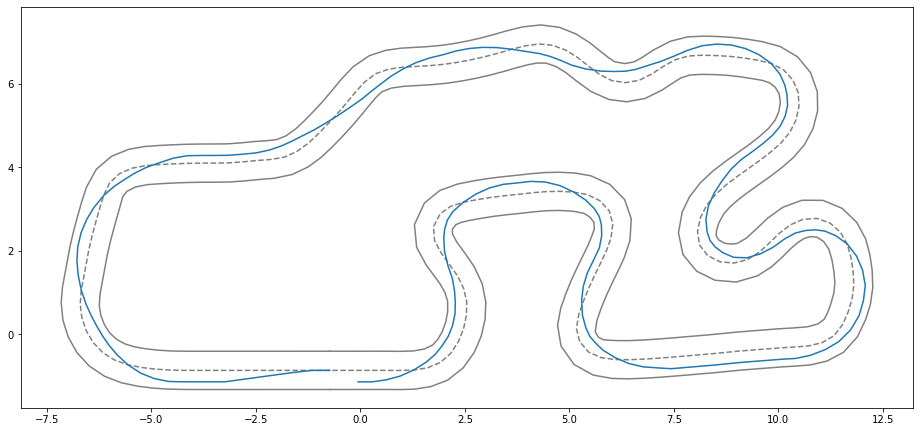

In [21]:
fig = plt.figure(figsize=(16, 16))
plt.axes().set_aspect('equal')

# センターラインのプロット
x = [p[0] for p in arr]
y = [p[1] for p in arr]
plt.plot(x, y, linestyle="dashed", color="gray")

# 内側、外側のプロット
x = [p[2] for p in arr]
y = [p[3] for p in arr]
# plt.axes().set_aspect('equal')
plt.plot(x, y, color="gray")

x = [p[4] for p in arr]
y = [p[5] for p in arr]
# plt.axes().set_aspect('equal')
plt.plot(x, y, color="gray")

# 計算した経路のプロット
pts = []
for i in range(len(path)):
    pts.append(wp_auged[(start_p[0] + i) % len(wp_auged)][path[i]])
x = [p[0] for p in pts]
y = [p[1] for p in pts]
plt.plot(x, y)